<a href="https://colab.research.google.com/github/cooperhammond/nn-interpretability/blob/master/Visualizing_Polytopes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import seed

Set up training data for the iris dataset. Key is that we're only keeping two of the datapoints

In [2]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

iris = datasets.load_iris()
X = iris.data[:, 2:4]
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)
train_labels = to_categorical(y_train)
test_labels = to_categorical(y_test)

Generic method for creating a model for the iris dataset.

In [3]:
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Dropout
from sklearn.preprocessing import normalize

def gen_model(l1=40, l2=20, bias_initializer = 'random_uniform'):
    model = Sequential()
    model.add(InputLayer(input_shape=(2,)))
    model.add(Dense(l1, activation='relu', bias_initializer=bias_initializer))
    model.add(Dense(l2, activation='relu', bias_initializer=bias_initializer))
    model.add(Dense(3, activation='softmax', bias_initializer=bias_initializer))

    model.summary()

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )
    
    return model

In [4]:
m = gen_model(l1=8, l2=5)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 24        
                                                                 
 dense_1 (Dense)             (None, 5)                 45        
                                                                 
 dense_2 (Dense)             (None, 3)                 18        
                                                                 
Total params: 87
Trainable params: 87
Non-trainable params: 0
_________________________________________________________________


In [5]:
def gen_layer_polytopes_deprecated(model, layer_idx, prev_activations, free_dim=2, fd_placement="start"):
    """
    :param int|list free_dim: if int, that many free_dimensions; if list, use the elements as the free 
                              dimensions
    :param str|list fd_placement: if str: "start" would replace the first n prev_activations with the 
                                  generated free dimensions, "end" would replace the end. Only use if
                                  free_dim is int
    """
    prev_activations = list(prev_activations)
    activations = []
    layer = model.layers[layer_idx]
    layer_weights = layer.get_weights()
    
    if type(free_dim) is int:
        if fd_placement is "start":
            free_dim = list(range(0, free_dim))
        elif fd_placement is "end":
            free_dim = list(range(len(prev_activations) - free_dim, len(prev_activations)))
        else:
            free_dim = []
        
    for neuron_idx in range(0, layer_weights[0].shape[-1]):
        weights = [weights[neuron_idx] for weights in layer_weights[0]]
        bias = layer_weights[1][neuron_idx]
        
        eq = []
        other = 0 
        
        for i, w in enumerate(weights):
            if i in free_dim:
                eq.append(w)
            else:
                other += w * prev_activations[i]
        eq.append(other + bias)
        
        if len(eq) == 1:
            eq[0] = max(eq[0], 0)
            
        if len(free_dim) == 0:
            eq = eq[0]
        
        activations.append(eq)

    return activations

gen_layer_polytopes_deprecated(m, 0, X[40], free_dim=2)

<>:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:17: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:17: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-5-0539454ed827>:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if fd_placement is "start":
<ipython-input-5-0539454ed827>:17: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif fd_placement is "end":


[[-0.7243437, 0.59889007, 0.018512312322854996],
 [-0.32956812, 0.1531474, -0.03559308126568794],
 [0.51565087, -0.5852289, 0.021169137209653854],
 [0.48142624, -0.60876375, 0.01711687073111534],
 [0.0027799606, -0.1026606, -0.035889483988285065],
 [-0.5978347, 0.2787869, -0.04365590959787369],
 [-0.44761592, -0.1712985, 0.012297771871089935],
 [-0.55895877, 0.017164528, 0.015189338475465775]]

A method for generating the polytopes of a layer, taking the model and the activations from the previous layer.

In [7]:
def gen_layer_polytopes(model, layer_idx, prev_activations):
    """
    :param list(int|list(int)) prev_activations: if element is int, this is dealt with as an activation/feature 
        of the previous layer; if element is another list, then it is dealt with as the coefficients of a free 
        dimension, meant to track free dimensions through multiple layers of the network
    """
    prev_activations = list(prev_activations)
    activations = []
    layer = model.layers[layer_idx]
    layer_weights = layer.get_weights()
            
    for neuron_idx in range(0, layer_weights[0].shape[-1]):
        weights = [weights[neuron_idx] for weights in layer_weights[0]]
        bias = layer_weights[1][neuron_idx]
        
        
        # The math itself
        activation = []
        for i, w in enumerate(weights):         
            if type(prev_activations[i]) == list:
                
                if len(activation) <= i:
                    activation.append([0] * len(prev_activations[i]))
                
                for j, coeff in enumerate(prev_activations[i]):
                    activation[i][j] += coeff * w
        
            else:
                activation.append(prev_activations[i] * w)
                
        # Reformatting terms
        variables = []
        remainder = bias
        l = 0
        for i, element in enumerate(activation):
            if type(element) is list:
                remainder += element[-1]
                num_vars = len(element[:-1])
                if len(variables) < num_vars:
                    variables = [0] * num_vars
                
                for v_idx, var in enumerate(element[:-1]):
                    variables[v_idx] += var
            else:
                remainder += element
                l += 1
                
        if l == len(activation):
            activation = max(0, remainder)
        else:
            activation = variables + [remainder]
        
        activations.append(activation)

    return activations

# l1_polytopes = gen_layer_polytopes(m, 0, [[1, 0, 0], [0, 1, 0]])
# l2_polytopes = gen_layer_polytopes(m, 1, l1_polytopes)
# l3_polytopes = gen_layer_polytopes(m, 2, l2_polytopes)

# print(l1_polytopes)
# print(l2_polytopes)
# print(l3_polytopes)

In [8]:
%%time
gen_layer_polytopes(m, 0, [[1,0,0],[0,1,0]])

CPU times: user 2.51 ms, sys: 1.14 ms, total: 3.64 ms
Wall time: 1.77 ms


[[-0.7243437170982361, 0.5988900661468506, 0.018512312322854996],
 [-0.32956811785697937, 0.1531473994255066, -0.03559308126568794],
 [0.5156508684158325, -0.5852289199829102, 0.021169137209653854],
 [0.4814262390136719, -0.6087637543678284, 0.01711687073111534],
 [0.0027799606323242188, -0.10266059637069702, -0.035889483988285065],
 [-0.5978347063064575, 0.27878689765930176, -0.04365590959787369],
 [-0.44761592149734497, -0.17129850387573242, 0.012297771871089935],
 [-0.5589587688446045, 0.017164528369903564, 0.015189338475465775]]

In [9]:
def get_spline_code(model, instance, codify=True): 

    total_activations = []
    prev_activations = instance
        
    for i in range(0, len(model.layers)):
        prev_activations = gen_layer_polytopes(model, i, prev_activations)
        total_activations.append(prev_activations)
    
    if codify:
        return [1 if activation > 0 else 0 for layer in total_activations for activation in layer]
    else:
        return total_activations
    
def hamming_distance(model, instance1, instance2):
    c1 = get_spline_code(model, instance1)
    c2 = get_spline_code(model, instance2)
    dist = 0.
    for i, _ in enumerate(c1):
        if c1[i] != c2[i]:
            dist += 1
    
    return dist

def euclidean_distance(model, instance1, instance2):
    from math import sqrt
    s = 0.
    c1 = get_spline_code(model, instance1)
    c2 = get_spline_code(model, instance2)
    
    for idx, _ in enumerate(c1):
        s += (c1[idx] - c2[idx]) ^ 2
    
    return sqrt(s)

def get_boundary_density(model, instance1, instance2):
    ham_dist = hamming_distance(model, instance1, instance2)
    euc_dist = euclidean_distance(model, instance1, instance2)
    
    return ham_dist / euc_dist

# a = X[0]
# b = X[20]
# print(hamming_distance(model, a, b))
# print(euclidean_distance(model, a, b))
# print(get_boundary_density(model, a, b))

In [10]:
def generate_polytope_bounds(model, layer_idx, features, ret_all=True, solve=True): 

    total_activations = []
    prev_activations = list(features)
        
    for i in range(0, layer_idx + 1):
        if i == layer_idx:
            prev_activations = gen_layer_polytopes(model, i, prev_activations)
        else:
            prev_activations = gen_layer_polytopes(model, i, prev_activations)

        total_activations.append(prev_activations)
    
    activations = total_activations
    if not ret_all:
        activations = total_activations[layer_idx]

    if solve:
        #      slope,        intercept
        return [[[-a[1]/a[0], -a[2]/a[0]] for a in bounds] for bounds in activations]
    else:
        return activations
    
generate_polytope_bounds(m, 2, [[1,0,0],[0,1,0]], ret_all=True, solve=True)

[[[0.8268037010744563, 0.025557358869648814],
  [0.4646911856078476, -0.10799916417016421],
  [1.1349324820897388, -0.04105323680475718],
  [1.2645005714998852, -0.035554503149192174],
  [36.92879502572899, 12.910069146655232],
  [0.466327723563764, -0.07302337776203834],
  [-0.38269081962659474, 0.027473937544383972],
  [0.03070804024665987, 0.027174345089643896]],
 [[0.19256986038331803, 0.1388673184941155],
  [0.4039107390846402, -0.058965532137370234],
  [0.3421632156491934, 0.017823884150874724],
  [0.418571343304667, -0.045193040003551226],
  [1.6806360870682548, -0.020734546873118476]],
 [[0.4830341167491548, 0.03579085680686355],
  [0.7051804534524206, -0.029755906401833117],
  [0.15502714390374525, 0.07770260757449081]]]

In [11]:
%%time

instance = list(X[40])
instance[0] = [1, 0, 0]
instance[1] = [0, 1, 0]
generate_polytope_bounds(m, len(m.layers)-1, instance, ret_all=True, solve=True)

CPU times: user 5.12 ms, sys: 0 ns, total: 5.12 ms
Wall time: 3.95 ms


[[[0.8268037010744563, 0.025557358869648814],
  [0.4646911856078476, -0.10799916417016421],
  [1.1349324820897388, -0.04105323680475718],
  [1.2645005714998852, -0.035554503149192174],
  [36.92879502572899, 12.910069146655232],
  [0.466327723563764, -0.07302337776203834],
  [-0.38269081962659474, 0.027473937544383972],
  [0.03070804024665987, 0.027174345089643896]],
 [[0.19256986038331803, 0.1388673184941155],
  [0.4039107390846402, -0.058965532137370234],
  [0.3421632156491934, 0.017823884150874724],
  [0.418571343304667, -0.045193040003551226],
  [1.6806360870682548, -0.020734546873118476]],
 [[0.4830341167491548, 0.03579085680686355],
  [0.7051804534524206, -0.029755906401833117],
  [0.15502714390374525, 0.07770260757449081]]]

In [28]:
def graph_polytope_boundaries(polytope_bounds, epoch=0):
    import matplotlib

    fig = plt.figure(epoch)
    fig.clf()
    ax = fig.add_subplot()

    l = 3
    ax.set_xlim([-l, l])
    ax.set_ylim([-l, l])
    
    if type(polytope_bounds) == list:
        polytope_bounds = [l for bounds in polytope_bounds for l in bounds]
    
    for line in polytope_bounds:                
            slope = line[0]
            intercept = line[1]

            x = np.linspace(-l, l, int(l * 15))
            ax.plot(x, slope * x + intercept, '-', color="black", linewidth=0.5)

            plt.savefig(f'./img/img_{epoch}.png', 
                transparent = False,  
                facecolor = 'white'
               )

In [26]:
def make_polytope_gif(folder, epochs):
    import imageio
    import os

    frames = [] 

    for epoch in range(0, epochs):
        image = imageio.v2.imread(f'./{folder}/img_{epoch}.png')
        frames.append(image)

    gif_path = "./img/out.gif"
    imageio.mimsave(gif_path, frames, duration = 500)

    from IPython.display import Image
    display(Image(data=open(gif_path,'rb').read(), format='png'))

In [14]:
def explore_polytope_evolution(history, view_size=2.5, fill=False, layer_slice=slice(0, None)):
    import plotly.express as px
    from plotly.offline import iplot
    import plotly.graph_objects as pgo
    
    r = np.linspace(-100, 100, 100)
    nested_data = []
    for epoch_idx, epoch in enumerate(history):
        layers = []
        for layer_idx, layer in enumerate(epoch):
            neurons = []
            for neuron_idx, bound in enumerate(layer):
                np.random.seed([layer_idx, neuron_idx])
                fillcolor = 'rgba' + \
                    str(tuple(np.random.choice(range(256), size=3)) + tuple([0.1]))
                filltype = 'none'
                if fill:
                    filltype = 'tonextx'
                    neurons.append(pgo.Scatter(
                        visible=False,
                        showlegend=False,
                        x = r,
                        y = r * 0 - 100
                    ))
                
                line = pgo.Scatter(
                    visible=False,
                    line=dict(
                        color='#000000', 
                        width=1
                    ),
                    name="L: %d, N: %d" % (layer_idx, neuron_idx),
                    showlegend = False,
                    x = r,
                    y = bound[0] * r + bound[1],
                    fill=filltype,
                    fillcolor=fillcolor,
                    fillpattern=dict(fillmode='replace')
                )
                neurons.append(line)
            layers.append(neurons)
        nested_data.append(layers[layer_slice])
    
    num_epochs = len(nested_data)
    num_layers = len(nested_data[0])
    
    # difficulty is that this differs depending on the layer index, thus lambdas for 
    # dynamic sizes
    epoch_size = sum([len(layer) for layer in nested_data[0]])
    layer_size = lambda i: len(nested_data[0][i])
    layer_offset = lambda i: sum([len(layer) for layer in nested_data[0][:i]])
    access_n = lambda e, l, n: n + layer_offset(l)*l + epoch_size*e

    visible_index = 0
        
    for layer in nested_data[0]:
        for line in layer:
            line['visible'] = True
                
    flat_data = []
    for epoch in nested_data:
        for layer in epoch:
            for bound in layer:
                flat_data.append(bound)
    
    epoch_steps = []
    layer_step_steps = []
    for e in range(0, num_epochs):
        epoch_step = dict(
            method = 'update',
            args = [{'visible': [False] * len(flat_data)}],
            label = str(e)
        )
        
        layer_steps = []

        for l in range(0, num_layers):
            layer_step = dict(
                method = 'restyle',
                args = ['visible', [False] * len(flat_data)],
            )
    
            for n in range(0, layer_size(l)):
                n_idx = access_n(e, l, n)
                epoch_step['args'][0]['visible'][n_idx] = True
                layer_step['args'][1][n_idx] = True
                
            layer_steps.append(layer_step)

        epoch_steps.append(epoch_step)
        layer_step_steps.append(layer_steps)

    sliders = [pgo.layout.Slider(
        active = visible_index,
        currentvalue = {"prefix": "Epoch: "},
        steps = epoch_steps
    )]

    layout = pgo.Layout(
        sliders=sliders,
        yaxis=dict(scaleanchor="x", scaleratio=1)
    )

    l = view_size
    viewing_window = [[-l, l], [-l, l]]
    fig = pgo.Figure(data=flat_data, layout=layout, 
                     layout_xaxis_range=viewing_window[0],
                     layout_yaxis_range=viewing_window[1])

    iplot(fig)
        
#explore_polytope_evolution(history)

In [16]:
class PolytopeVisualizationCallback(keras.callbacks.Callback):
    def __init__(self, viz_layer, instance, history, every=1, free_dim=2):
        self.viz_layer = viz_layer
        self.history = history
        self.free_dim = free_dim
        self.every = every
        
        self.instance = list(instance)
        for i, dim in enumerate(range(0, free_dim)):
            self.instance[i] = [0] * (free_dim + 1)
            self.instance[i][i] = 1
        
    def on_epoch_begin(self, epoch, logs=None):
        if epoch % self.every == 0:
            polytope_bounds = generate_polytope_bounds(self.model, 
                                                       self.viz_layer, 
                                                       self.instance)
            graph_polytope_boundaries(polytope_bounds, epoch=epoch)
            history.append(polytope_bounds)

Now we can actually dive into visualizing the polytopes. First, we will train the model, with the default parameters.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 40)                120       
                                                                 
 dense_7 (Dense)             (None, 20)                820       
                                                                 
 dense_8 (Dense)             (None, 3)                 63        
                                                                 
Total params: 1,003
Trainable params: 1,003
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
4/4 [==============================] - 1s 4ms/step - loss: 1.6939 - accuracy: 0.3333
Epoch 2/30
4/4 [==============================] - 0s 4ms/step - loss: 1.4965 - accuracy: 0.3333
Epoch 3/30
4/4 [==============================] - 0s 4ms/step - loss: 1.3344 - accuracy: 0.3333
Epoch 4/30
4/4 [============

<ipython-input-28-08ca97e4f231>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(epoch)


Epoch 21/30
4/4 [==============================] - 0s 3ms/step - loss: 0.8877 - accuracy: 0.4444
Epoch 22/30
4/4 [==============================] - 0s 4ms/step - loss: 0.8812 - accuracy: 0.4667
Epoch 23/30
4/4 [==============================] - 0s 4ms/step - loss: 0.8746 - accuracy: 0.5333
Epoch 24/30
4/4 [==============================] - 0s 4ms/step - loss: 0.8672 - accuracy: 0.5481
Epoch 25/30
4/4 [==============================] - 0s 4ms/step - loss: 0.8585 - accuracy: 0.6148
Epoch 26/30
4/4 [==============================] - 0s 4ms/step - loss: 0.8507 - accuracy: 0.6222
Epoch 27/30
4/4 [==============================] - 0s 3ms/step - loss: 0.8438 - accuracy: 0.6444
Epoch 28/30
4/4 [==============================] - 0s 3ms/step - loss: 0.8354 - accuracy: 0.6444
Epoch 29/30
4/4 [==============================] - 0s 3ms/step - loss: 0.8268 - accuracy: 0.6593
Epoch 30/30
4/4 [==============================] - 0s 3ms/step - loss: 0.8186 - accuracy: 0.6593


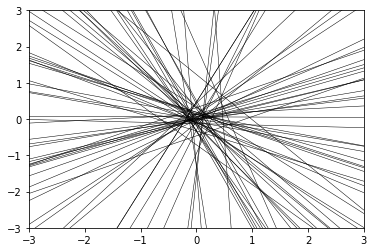

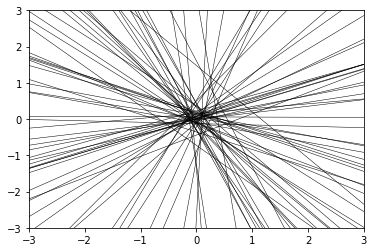

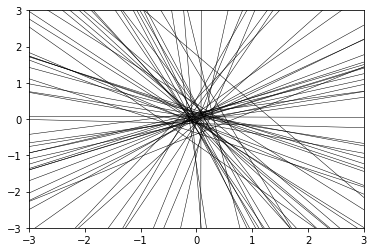

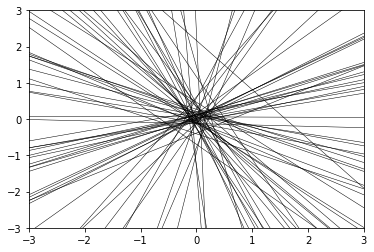

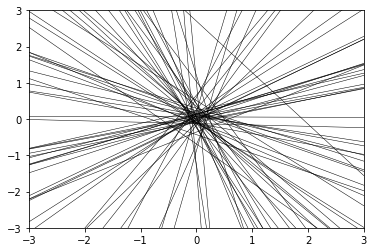

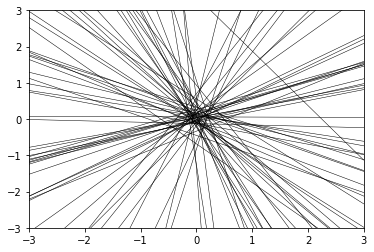

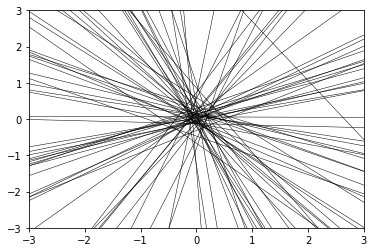

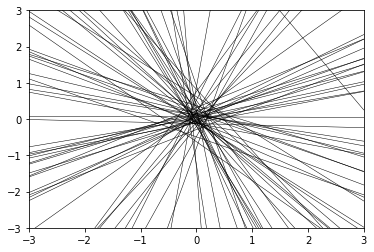

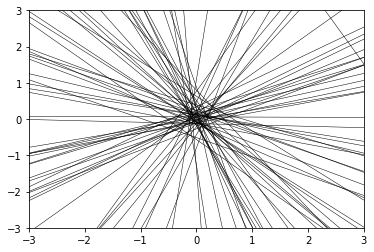

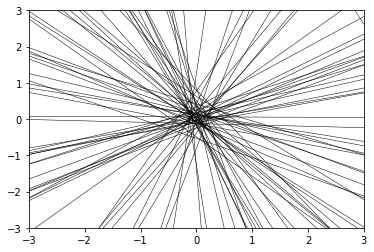

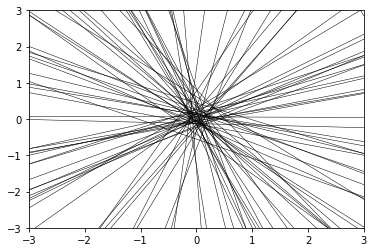

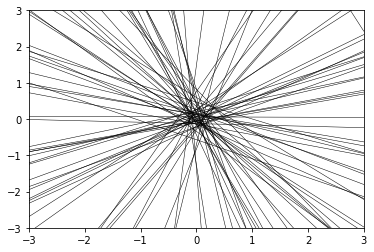

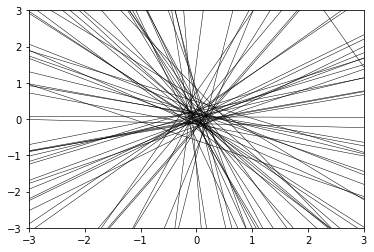

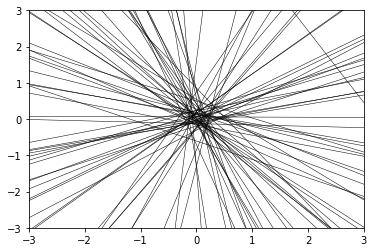

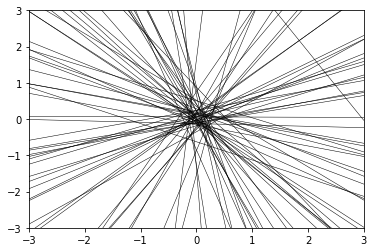

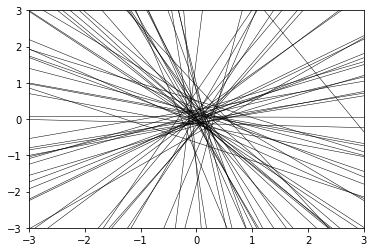

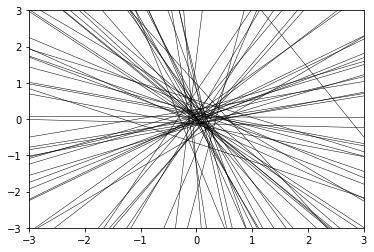

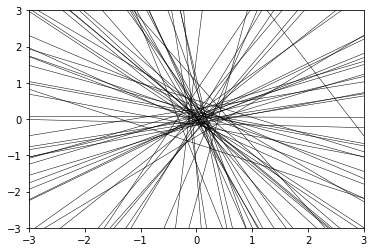

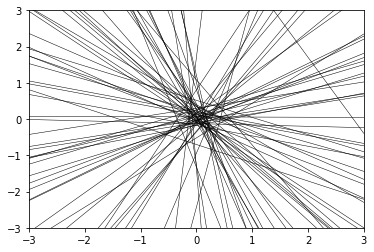

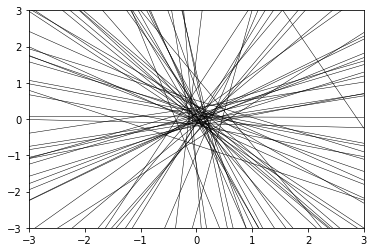

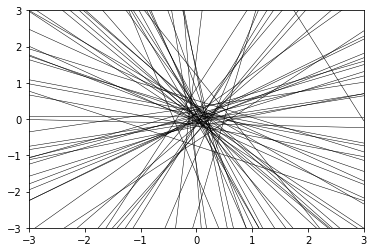

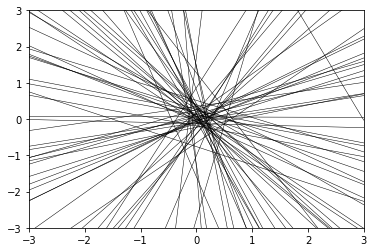

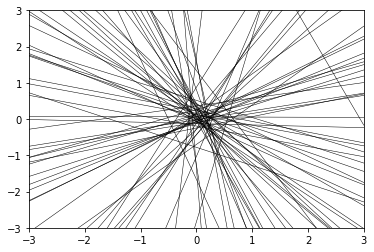

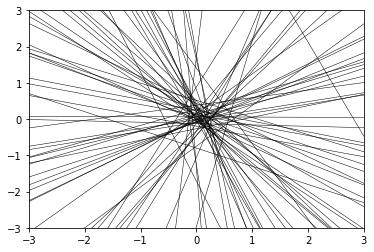

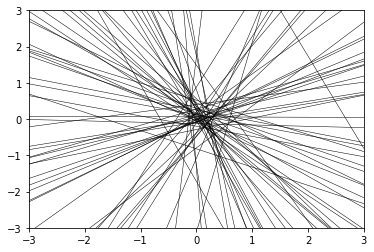

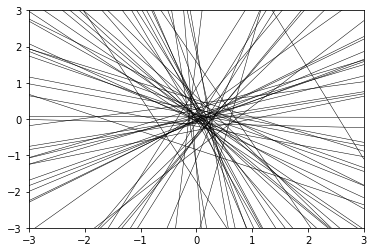

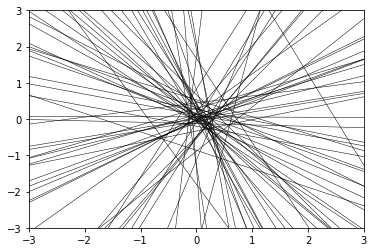

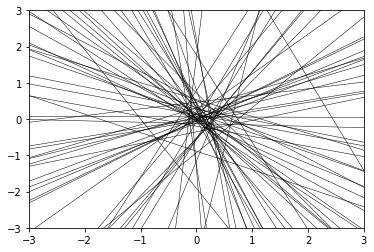

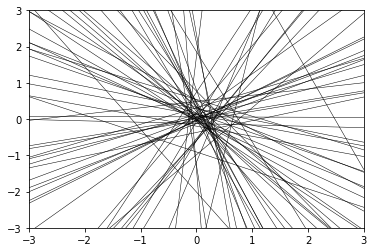

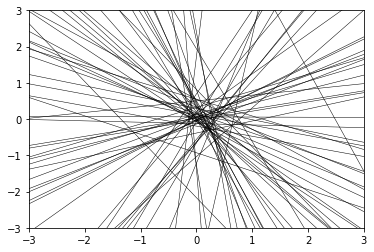

In [29]:
model = gen_model()
epochs = 30
history = []
model.fit(
    X_train, 
    train_labels, 
    epochs=epochs, 
    batch_size=40, 
    callbacks=[PolytopeVisualizationCallback(1, X[40], history)]
)

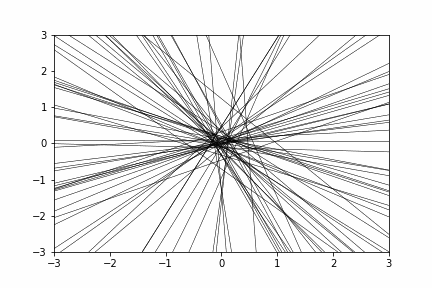

In [33]:
make_polytope_gif("./img", epochs)

In [16]:
#explore_polytope_evolution(history)

In [17]:
#explore_polytope_evolution(history, layer_slice=slice(0, 1))

By selecting a pretty arbitrary set of points, one above one of these lines, and one above a different line, we can expect the hamming distance to differ by one, so one neuron will fire differently between these two instances, only differing by `.01`!

In [18]:
hamming_distance(model, [1.76332, 5.04], [1.76332, 5.06])

0.0

In [ ]:
explore_polytope_evolution(history, layer_slice=slice(1, 2))

In [20]:
#explore_polytope_evolution(history, fill=True, layer_slice=slice(1,2))

In [36]:
%matplotlib notebook
from ipywidgets import interact
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.widgets import RangeSlider, Slider

    
def explore_polytopes(history):
    
    def set_visibility(tot_lines, value, epoch_slice=slice(None), layer_slice=slice(None)):
        for epoch in tot_lines[epoch_slice]:
            for layer in epoch[layer_slice]:
                for line in layer:
                    line.set_visible(value)
            
    def update(val):
        set_visibility(tot_lines, False)
        set_visibility(tot_polys, False)

        
        epoch = epoch_slider.val
        epoch_slice = slice(epoch, epoch+1)
        layer_min = layer_slider.val[0]
        layer_max = layer_slider.val[1]
        layer_slice = slice(layer_min, layer_max)
        set_visibility(tot_lines, True, epoch_slice, layer_slice)   
        set_visibility(tot_polys, True, epoch_slice, layer_slice)
#         set_visibility(tot_intersects, True, init_slice, init_slice)
#         ax.relim()
#         ax.autoscale_view()
        
        lines = []
        for epoch in tot_lines[epoch_slice]:
            for layer in epoch[layer_slice]:
                for line in layer:
                    lines.append(line)
        
        fig.canvas.draw_idle()
    
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    x = np.linspace(-100, 100, 100)
    tot_lines = []
    tot_polys = []
    tot_intersects = []
    for epoch in history:
        layer_lines = []
        layer_polys = []
        layer_intersects = []
        for layer in epoch:
            lines = []
            for line in layer:
                line_obj = Line2D(x, line[0]*x + line[1])
                line_obj.set_visible(False)
                ax.add_line(line_obj)
                lines.append(line_obj)
            layer_lines.append(lines)

#             intersections, mappings = find_intersections(layer)
#             edges = get_edges(intersections, layer, mappings)
#             cycles = find_chordless_cycles(edges)
#             polys = convert_cycles_to_polygons(cycles, intersections)
#             for poly in polys:
#                 poly.set_visible(False)
#                 ax.add_patch(poly)
#             pts = []
#             for intersection in intersections:
#                 if intersection[0] > 20:
#                     print(intersection)
# #                 pt = ax.plot(intersection[0], intersection[1])[0]
# #                 pt.set_visible(False)
# #                 pts.append(pt)
#             layer_polys.append(polys)
#             layer_intersects.append(pts)

        tot_lines.append(layer_lines)
        tot_polys.append(layer_polys)
        tot_intersects.append(layer_intersects)
    
    init_slice = slice(0, 1)
    set_visibility(tot_lines, True, init_slice, init_slice)
    set_visibility(tot_polys, True, init_slice, init_slice)
#     set_visibility(tot_intersects, True, init_slice, init_slice)

    num_epochs = len(history)
    epoch_slider_placement = plt.axes([0.2, 0.02, 0.6, 0.03])
    epoch_slider = Slider(
        epoch_slider_placement, 'Epoch', 0, num_epochs-1,
        valinit=0, valstep=1
    )
    epoch_slider.on_changed(update)

    num_layers = len(history[0])
    layer_slider_placement = plt.axes([0.03, 0.2, 0.0225, 0.63])
    layer_slider = RangeSlider(
        layer_slider_placement, 'Layer', 0, num_layers,
        valinit=[0, num_layers-1], valstep=1, orientation="vertical"
    )
    layer_slider.on_changed(update)

    plt.show()

<IPython.core.display.Javascript object>


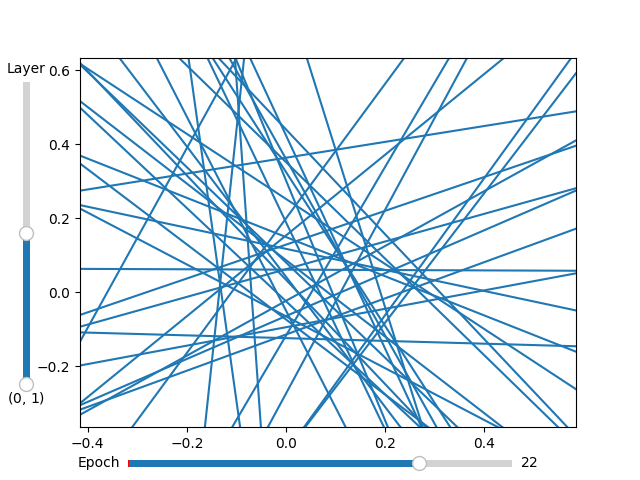

In [37]:
explore_polytopes(history)

In [99]:
from matplotlib.patches import Polygon

def find_intersections(lines):
    intersections = []
    mappings = []
    
    for i in range(len(lines)):
        for j in range(i+1, len(lines)):
            m1, b1 = lines[i]
            m2, b2 = lines[j]
            if m1 == m2:
                continue  # lines are parallel
            x = (b2 - b1) / (m1 - m2)
            y = m1 * x + b1
            intersection = (x, y)
            intersections.append(intersection)
            intersection_idx = len(intersections) - 1
            
            mappings.append((intersection_idx, i))
            mappings.append((intersection_idx, j))

    return intersections, mappings

def dist(pt1, pt2):
    from math import sqrt
    return sqrt( (pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2 )

def get_edges(intersections, lines, mappings):
    # List[Tuple[intersection idx1, intersection idx2]]
    edges = []
    
    for i, intersection in enumerate(intersections):
        intersection_lines = [m[1] for m in mappings if m[0] == i]
                
        conxs_idxs = []
        for j, line_idx in enumerate(intersection_lines):
            possible_conx_intersections_idxs = [m[0] for m in mappings if m[1] == line_idx]
            
            # What I am about to do could be far more efficient, but it'll work on the
            # relatively small scale this runs at. If it was to be made more efficient,
            # having an already ordered data structure could provide an equivalent of the
            # distance calculation in a more efficient manner.
            closest2_idxs = [-1, -1]
            closest2_dist = [float('inf'), float('inf')]
            for conx_idx in possible_conx_intersections_idxs:
                if conx_idx == i:
                    continue
                d = dist(intersection, intersections[conx_idx])
                if d < closest2_dist[0]:
                    closest2_idxs[1] = closest2_idxs[0]
                    closest2_dist[1] = closest2_dist[0]
                    closest2_idxs[0] = conx_idx
                    closest2_dist[0] = d
                elif d < closest2_dist[1]:
                    closest2_idxs[1] = conx_idx
                    closest2_dist[1] = d
            
            conxs_idxs += [idx for idx in closest2_idxs if idx != -1]
        
        edges.append(sorted(conxs_idxs))
    
    # at this point, what is returned is a list, where the index of each element 
    # corresponds to the intersections array. The element itself is a list that contains
    # the indexes of the intersection array that it connects to.
    return edges

def find_chordless_cycles(graph):
    cycles = []

    def dfs(v, path):
        # add the current vertex to the path
        path.append(v)

        # check for a cycle
        for u in graph[v]:
            if u in path:
                loc = path.index(u)
                cycle_path = path[loc:]
                if len(cycle_path) > 2:
                    cycles.append(cycle_path)
            elif u not in path:
                dfs(u, path)

        # remove the current vertex from the path
#         path.pop()

    # perform a depth-first search from each vertex
    dfs(0, [])

    # filter out cycles that contain chords
    chordless_cycles = []
    for cycle in cycles:
        is_chordless = True
        for i in range(len(cycle)):
            for j in range(i+2, len(cycle)):
                if cycle[j] in graph[cycle[i]] and cycle[j-1] in graph[cycle[i+1]]:
                    is_chordless = False
                    break
            if not is_chordless:
                break
        if is_chordless:
            chordless_cycles.append(cycle)

    return chordless_cycles

def convert_cycles_to_polygons(cycles, nodes, color=lambda i: np.random.rand(3,)):
    polygons = []
    for i, cycle in enumerate(cycles):
        points = [nodes[v] for v in cycle]
        #print(points)
        polygon = Polygon(points, closed=True, facecolor=color(i))
        polygons.append(polygon)
        
    return polygons

lines = history[29][0]
intersections, mappings = find_intersections(lines)
edges = get_edges(intersections, lines, mappings)
print(len(intersections))
print(len(np.unique(intersections, axis=0)))
print(len(edges))
print(len(np.unique(edges, axis=0)))

print(max(intersections, key=lambda i: i[0]))

[edge for edge in edges if len(edge) == 3]
# cycles = find_chordless_cycles(edges)
# polygons = convert_cycles_to_polygons(cycles, intersections)

# fig, ax = plt.subplots()

# for i, polygon in enumerate(polygons):
#     print(cycles[i])
#     points = [intersections[v] for v in cycles[i]]
#     for pt in points:
#         print(pt)
#         ax.plot(pt[0], pt[1], 'r.')
#     ax.add_patch(polygon)

# # for intersection in intersections:
# #     x, y = intersection
# #     ax.plot(x, y, 'r.')

# print(len(cycles))
# print(len(polygons))

# ax.relim()
# ax.autoscale_view()
# plt.show()

780
780
780
737
(912.6293474589444, 582.1189098995059)


[]

Let's see what can be determined 

$$
a^i_j = max(\begin{bmatrix} w^{i-1}_{1,j} & . . . & w^{i-1}_{len(a^{i-1}),j}\end{bmatrix}
            \begin{bmatrix} a^{i-1}_1\\ ... \\ a^{i-1}_{len(a^{i-1})}\end{bmatrix} + b^i_j, 0)
$$

iris sepals

free dimensions could be outputs just as much as inputs
 * this is not possible because the $max$ function (key to RELU) is not invertible ... But, inverting the $max$ function may not be necessary to run the variables through backwards. Either way, it seems like it would be far too much effort when I have a "working" visualization system right now

Two problems:

1) cutting a slice through high dimensional space

2) handling convolutional layers -- how do those translate to polytopes?

Where to take this next:

- [ ] a "suite" of polytope interpretation tools, consisting of:
* given multiple class examples, calculate the Euclidean distance between their spline codes, drawn from their the class example's activation vector
  * would require an ability to map from the activation vector to the spline code: "To calculate the polytope boundary density between two points, we simply divide the Hamming distance in between their spline codes by the Euclidean distance between them. The polytope densities are normalized by dividing by the average polytope density between all pairs of vectors (both intra and inter class)."
* as